# Рынок заведений общественного питания Москвы



Решено открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Чтобы обратиться к инвесторам нужно изложить текущее положение дел на рынке и обьяснить как заведение сможет удержать популярность на долгое время, если посетителям наскучат роботы-официанты.

Даны открытые данные о заведениях общественного питания в Москве, с помощью которых нужно сделать общие выводы, дать рекомендации о виде заведения, количестве посадочных мест и локации, а также прокомментировать возможность развития сети.

Для этого нужно:
- Исследовать соотношение видов объектов общественного питания по количеству;
- Исследовать соотношение сетевых и несетевых заведений по количеству;
- Установать для какого вида объекта общественного питания характерно сетевое распространение;
- Узнать, что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?
- Описать среднее количество посадочных мест для каждого вида объекта общественного питания. Узнать какой вид предоставляет в среднем самое большое количество посадочных мест;
- Построить график с топ-10 улиц по количеству объектов общественного питания;
- Найти число улиц с одним объектом общественного питания.

# Описание данных
Таблица rest_data: 
- `id` — идентификатор объекта;
- `object_name` — название объекта общественного питания;
- `chain` — сетевой ресторан;
- `object_type` — тип объекта общественного питания;
- `address` — адрес;
- `number` — количество посадочных мест.

## Предобработка данных

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
from numpy import median
import re

In [55]:
rest_data = pd.read_csv('/Users/polina_lunyova/Documents/It/projects/7_Как_рассказать_историю_с_помощью_данных/rest_data.csv')
display(rest_data.head())
display(rest_data.info())
display(rest_data.describe())

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


In [56]:
# приведем все записи в стодбцах "object_name" и "address" к нижнему регистру
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data['address'] = rest_data['address'].str.lower()

# переименование записей столбца "chain" и "object_type"
rest_data['chain'] = rest_data['chain'].replace("да", "сетевое заведение")
rest_data['chain'] = rest_data['chain'].replace("нет", "несетевое заведение")
rest_data['object_type'] = rest_data['object_type'].replace("предприятие быстрого обслуживания", 'фастфуд')
rest_data['object_type'] = rest_data['object_type'].replace("магазин (отдел кулинарии)", 'кулинария')

In [57]:
# смотрим наличие пропусков 
display(rest_data.isna().sum())

# наличие дубликатов
rest_data.duplicated().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

0

Столбцы id  и number могут влиять на наличие дубликатов тем, что адрес, название и тип заведения могут совпадать, поэтому посмотрим дубликаты в самих столбцах с данными. 

In [58]:
# посмотрим дубликаты в самих столбцах с данными
print('Количество дубликатов в данных:', rest_data.duplicated(subset=['object_name', 'chain', 'object_type', 'address']).sum())

Количество дубликатов в данных: 183


Действительно, имеются дубликаты. Рассмотрим эти данные ближе, т.к. это могут быть сетевые заведения находящиеся в одном здании.

In [59]:
# посмотрим эти данные 
rest_data[rest_data.duplicated(subset=['object_name', 'chain', 'object_type', 'address'])].head()

,id,object_name,chain,object_type,address,number
115,28614,комбинат питания мгту им.н.э.баумана,несетевое заведение,буфет,"город москва, бригадирский переулок, дом 3-5",12
580,149205,общественное питание,несетевое заведение,кафе,"город москва, павелецкая площадь, дом 1",35
581,149131,общественное питание,несетевое заведение,кафе,"город москва, павелецкая площадь, дом 1",39
1409,151267,альфорно,несетевое заведение,кафе,"город москва, город зеленоград, корпус 438",45
2375,28604,комбинат питания мгту им.н.э.баумана,несетевое заведение,столовая,"город москва, 2-я бауманская улица, дом 5, стр...",150


In [60]:
# удалим имеющиеся дубликаты
rest_data = rest_data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address']).reset_index(drop=True)
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,несетевое заведение,кафе,"город москва, улица егора абакумова, дом 9",48
1,77874,родник,несетевое заведение,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,несетевое заведение,кафе,"город москва, абельмановская улица, дом 6",95
3,21894,пиццетория,сетевое заведение,кафе,"город москва, абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,несетевое заведение,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50


In [61]:
# посмотрим распределение значений в столбце 'number'
rest_data['number'].value_counts() 

0      1583
40      826
20      716
30      678
10      627
       ... 
491       1
675       1
455       1
167       1
495       1
Name: number, Length: 315, dtype: int64

Данные в столбце с количеством посадочных мест распределены следующим образом: с увеличением количества мест уменьшается количество сетей, т.е. у большенства заведений наименьшее количество посадочных мест. Возможно больших(по количетству) ресторанов не так много(2-3 обьекта на сеть), а маленьких обьектов общественного питания большенство.

Удалены дубликаты т.к. это несетевые заведения, что противоречит предположению об метсонахождении в одном здании.

 Данные преобразованы и готовы к дальнейшему анализу.

## Анализ данных

# Cоотношение видов объектов общественного питания по количеству

In [62]:
object_type = (
    rest_data
    .pivot_table(index='object_type', values='id', aggfunc='count')
    .sort_values(by='id', ascending=False)
    .reset_index()
)
object_type.columns = ['object_type', 'count']
object_type['persent'] = (object_type['count'] / object_type['count'].sum() * 100).round(2)
object_type

,object_type,count,persent
0,кафе,6008,39.57
1,столовая,2575,16.96
2,ресторан,2275,14.98
3,фастфуд,1890,12.45
4,бар,853,5.62
5,буфет,570,3.75
6,кафетерий,393,2.59
7,закусочная,347,2.29
8,кулинария,272,1.79


In [64]:
# строим график соотношений видов объектов общественного питания
fig = px.bar(object_type, x='object_type', y='persent', title='Cоотношение видов объектов общественного питания', text='persent', height=700, width=700)
fig.update_xaxes(tickangle=45)
fig.update_traces(texttemplate='%{text:.4s}', textposition='inside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_title="Тип объекта общественного питания", yaxis_title="Доля от общего числа, %")
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.Bar: 'texttemplate'

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        base
            Sets where the bar base is drawn (in position axis
            units). In "stack" or "relative" barmode, traces that
            set "base" will be excluded and drawn in "overlay" mode
            instead.
        basesrc
            Sets the source reference on plot.ly for  base .
        cliponaxis
            Determines whether the text nodes are clipped about the
            subplot axes. To show the text nodes above axis lines
            and tick labels, make sure to set `xaxis.layer` and
            `yaxis.layer` to *below traces*.
        constraintext
            Constrain the size of text inside or outside a bar to
            be no larger than the bar itself.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on plot.ly for  customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            plotly.graph_objects.bar.ErrorX instance or dict with
            compatible properties
        error_y
            plotly.graph_objects.bar.ErrorY instance or dict with
            compatible properties
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on plot.ly for  hoverinfo .
        hoverlabel
            plotly.graph_objects.bar.Hoverlabel instance or dict
            with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}". https://github.com/d3/d3-3.x-api-
            reference/blob/master/Formatting.md#d3_format for
            details on the formatting syntax. The variables
            available in `hovertemplate` are the ones emitted as
            event data described at this link
            https://plot.ly/javascript/plotlyjs-events/#event-data.
            Additionally, every attributes that can be specified
            per-point (the ones that are `arrayOk: true`) are
            available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on plot.ly for  hovertemplate
            .
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on plot.ly for  hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on plot.ly for  ids .
        insidetextanchor
            Determines if texts are kept at center or start/end
            points in `textposition` "inside" mode.
        insidetextfont
            Sets the font used for `text` lying inside the bar.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        marker
            plotly.graph_objects.bar.Marker instance or dict with
            compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on plot.ly for  meta .
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        offset
            Shifts the position where the bar is drawn (in position
            axis units). In "group" barmode, traces that set
            "offset" will be excluded and drawn in "overlay" mode
            instead.
        offsetgroup
            Set several traces linked to the same position axis or
            matching axes to the same offsetgroup where bars of the
            same position coordinate will line up.
        offsetsrc
            Sets the source reference on plot.ly for  offset .
        opacity
            Sets the opacity of the trace.
        orientation
            Sets the orientation of the bars. With "v" ("h"), the
            value of the each bar spans along the vertical
            (horizontal).
        outsidetextfont
            Sets the font used for `text` lying outside the bar.
        r
            r coordinates in scatter traces are deprecated!Please
            switch to the "scatterpolar" trace type.Sets the radial
            coordinatesfor legacy polar chart only.
        rsrc
            Sets the source reference on plot.ly for  r .
        selected
            plotly.graph_objects.bar.Selected instance or dict with
            compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stream
            plotly.graph_objects.bar.Stream instance or dict with
            compatible properties
        t
            t coordinates in scatter traces are deprecated!Please
            switch to the "scatterpolar" trace type.Sets the
            angular coordinatesfor legacy polar chart only.
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textangle
            Sets the angle of the tick labels with respect to the
            bar. For example, a `tickangle` of -90 draws the tick
            labels vertically. With "auto" the texts may
            automatically be rotated to fit with the maximum size
            in bars.
        textfont
            Sets the font used for `text`.
        textposition
            Specifies the location of the `text`. "inside"
            positions `text` inside, next to the bar end (rotated
            and scaled if needed). "outside" positions `text`
            outside, next to the bar end (scaled if needed), unless
            there is another bar stacked on this one, then the text
            gets pushed inside. "auto" tries to position `text`
            inside the bar, but if the bar is too small and no bar
            is stacked on this one the text is moved outside.
        textpositionsrc
            Sets the source reference on plot.ly for  textposition
            .
        textsrc
            Sets the source reference on plot.ly for  text .
        tsrc
            Sets the source reference on plot.ly for  t .
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            plotly.graph_objects.bar.Unselected instance or dict
            with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        width
            Sets the bar width (in position axis units).
        widthsrc
            Sets the source reference on plot.ly for  width .
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xsrc
            Sets the source reference on plot.ly for  x .
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ysrc
            Sets the source reference on plot.ly for  y .
        

Наибольшую часть от видов общественного питания составляет "кафе"(40%) далее идут "столовая", "ресторан", "предприятие быстрого обслуживания" (по 12-16%).

# Cоотношение сетевых и несетевых заведений по количеству

In [65]:
chain = (
    rest_data
    .pivot_table(index='chain', values='id', aggfunc='count')
    .sort_values(by='id', ascending=False)
    .reset_index()
)
chain.columns = ['chain', 'count']
chain['persent'] = (chain['count'] / chain['count'].sum() * 100).round(2)
chain

,chain,count,persent
0,несетевое заведение,12234,80.58
1,сетевое заведение,2949,19.42


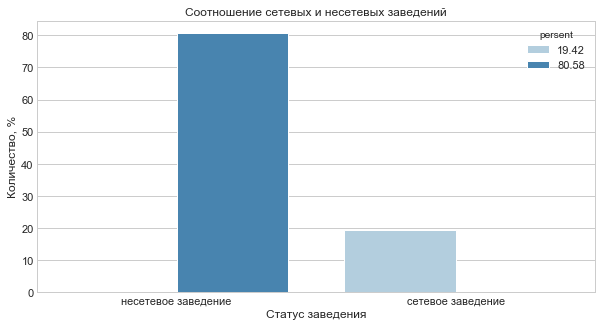

In [66]:
# просмотр стилей
plt.style.available
plt.style.use('seaborn-whitegrid')

# строим график сетевых и несетевых заведений
sns.barplot(x = 'chain', y='persent', hue = 'persent', data = chain, palette = 'Blues')  #seaborn-whitegrid  Blues  magma  seaborn-whitegrid
sns.set(rc={'figure.figsize':(10, 5)})
plt.title('Cоотношение сетевых и несетевых заведений')
plt.xlabel('Статус заведения')
plt.ylabel('Количество, %')
plt.show()

Основную часть составляют несетевые заведения (80%).

# Количество и характерность распространения сетевых объектов общественного питания

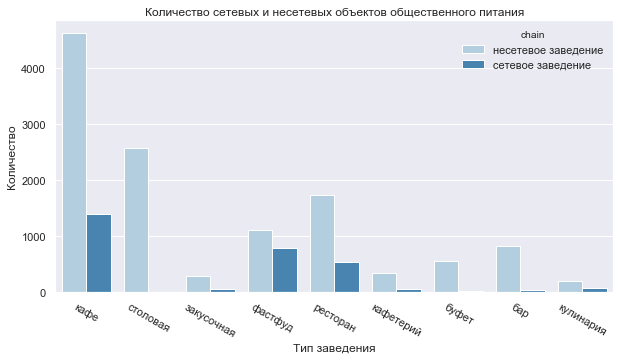

In [67]:
# строим график сетевых и несетевых объектов общественного питания
sns.countplot(x = 'object_type', hue = 'chain', data = rest_data, palette = 'Blues') 
plt.xticks(rotation=330)
plt.title('Количество сетевых и несетевых объектов общественного питания')
plt.xlabel('Тип заведения')
plt.ylabel('Количество')
plt.show()

Сетевое распространение в основном характерно для кафе, предприятий быстрого обслуживания и ресторанов.

# Характерность сетевых заведений по их количеству и посадочным местам

In [68]:
# выделяем таблица с сетевыми заведениями
rest_chain = rest_data.query('chain == "сетевое заведение"') 

# посчитаем количество сетевых заведений 
name_group = (
    rest_chain
    .pivot_table(index='object_name', values='id', aggfunc='count')
    .sort_values(by='id', ascending=False)
    .reset_index()
)
name_group.columns = ['object_name', 'count']

# найдем среднее значение посадочных мест в заведениях
number_group = rest_chain.pivot_table(index='object_name', values='number', aggfunc='median').reset_index()#.plot(x='cityCenters_nearest', y='price_meter', kind='scatter', alpha=0.3, grid=True)

# объеденим таблицы
chain_group = name_group.merge(number_group, on='object_name', how='left')
chain_group

,object_name,count,number
0,kfc,155,45.0
1,шоколадница,154,50.0
2,макдоналдс,148,79.0
3,бургер кинг,136,45.0
4,теремок,94,23.0
...,...,...,...
572,кафе «торнадо»,1,80.0
573,кафе «тапчан»,1,70.0
574,кафе «тануки»,1,150.0
575,кафе «суши сет»,1,7.0


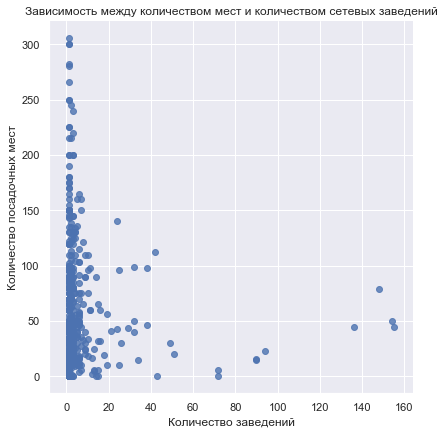

In [69]:
# Посмотрим зависимость между характеристиками сетевых заведений
sns.lmplot( x="count", y="number", data=chain_group, fit_reg=False, height=6)
plt.title('Зависимость между количеством мест и количеством сетевых заведений')
plt.xlabel('Количество заведений')
plt.ylabel('Количество посадочных мест')
plt.show()

Для сетевых заведений характерно множество объектов с небольшим числом посадочных мест.

# Второй вариант поиска зависимости между заведениями

In [70]:
# выделяем таблица с сетевыми заведениями
rest_chain = rest_data.query('chain == "сетевое заведение"') 

object_name_chain = rest_chain['object_name'].value_counts()
object_name_chain.head()

kfc            155
шоколадница    154
макдоналдс     148
бургер кинг    136
теремок         94
Name: object_name, dtype: int64

In [71]:
# создаем функцию для распределения сетей на большую / маленькую
def object_name_group(object_name):
    if object_name >= 15:
        return 'большая сеть'
    return 'маленькая сеть'

object_name_chain = object_name_chain.apply(object_name_group)
object_name_chain = object_name_chain.reset_index()
object_name_chain.columns = ['object_name','size_group']
object_name_chain.head()

,object_name,size_group
0,kfc,большая сеть
1,шоколадница,большая сеть
2,макдоналдс,большая сеть
3,бургер кинг,большая сеть
4,теремок,большая сеть


In [72]:
pd.options.mode.chained_assignment = None

# создаем функцию с классификациями количества мест
def number_group(number):
    if number >= 40:
        return 'много мест'
    return 'мало мест'

rest_chain['number'] = rest_chain['number'].apply(number_group)
rest_chain.head()


,id,object_name,chain,object_type,address,number
3,21894,пиццетория,сетевое заведение,кафе,"город москва, абрамцевская улица, дом 1",много мест
6,148815,брусника,сетевое заведение,кафе,"город москва, переулок сивцев вражек, дом 6/2",мало мест
13,22579,алло пицца,сетевое заведение,кафе,"город москва, улица авиаторов, дом 14",мало мест
16,144107,суши wok,сетевое заведение,фастфуд,"город москва, азовская улица, дом 3",мало мест
18,58565,тануки,сетевое заведение,ресторан,"город москва, большая академическая улица, дом 65",много мест


In [73]:
# объединяем таблицы
chain_group_full = rest_chain.merge(object_name_chain, on='object_name', how='left')
chain_group_full.head()

,id,object_name,chain,object_type,address,number,size_group
0,21894,пиццетория,сетевое заведение,кафе,"город москва, абрамцевская улица, дом 1",много мест,маленькая сеть
1,148815,брусника,сетевое заведение,кафе,"город москва, переулок сивцев вражек, дом 6/2",мало мест,маленькая сеть
2,22579,алло пицца,сетевое заведение,кафе,"город москва, улица авиаторов, дом 14",мало мест,большая сеть
3,144107,суши wok,сетевое заведение,фастфуд,"город москва, азовская улица, дом 3",мало мест,большая сеть
4,58565,тануки,сетевое заведение,ресторан,"город москва, большая академическая улица, дом 65",много мест,большая сеть


In [74]:
#
df1 = chain_group_full.query('size_group == "большая сеть" and number == "много мест"').count()
df2 = chain_group_full.query('size_group == "маленькая сеть" and number == "мало мест"').count()
df3 = chain_group_full.query('size_group == "большая сеть" and number == "мало мест"').count()
df4 = chain_group_full.query('size_group == "маленькая сеть" and number == "много мест"').count()

print('Количество больших сетей с большим количеством мест:', df1['id']) 
print('Количество маленьких сетей с небольшим количеством мест:', df2['id']) 
print('Количество больших сетей с небольшим количеством мест:', df3['id']) 
print('Количество маленьких сетей с большим количеством мест:', df4['id']) 


Количество больших сетей с большим количеством мест: 831
Количество маленьких сетей с небольшим количеством мест: 542
Количество больших сетей с небольшим количеством мест: 893
Количество маленьких сетей с большим количеством мест: 683


Для сетевых заведений характерно множество объектов с небольшим числом посадочных мест. 

# Среднее количество посадочных мест объектов общественного питания

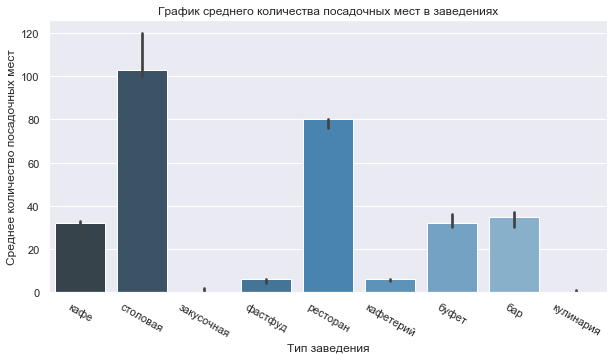

In [75]:
# строим график среднего количества посадочных мест
sns.barplot(x="object_type", y="number", data=rest_data, palette="Blues_d", estimator=median)
sns.set(rc={'figure.figsize':(16, 8)})
plt.xticks(rotation=330)
plt.title('График среднего количества посадочных мест в заведениях')
plt.xlabel('Тип заведения')
plt.ylabel('Среднее количество посадочных мест')
plt.show()

В столовых и ресторанах наибольшее среднее количество посадочных мест, далее идут кафе, буфеты и бары. Наименьшее количество посадочных мест в кафетериях и предприятиях быстрого обслуживания. В закусочных и магазинах их вовсе нет.

# Выделяем в отдельный столбец информацию об улице из столбца address

In [76]:
# удаляем лишние пробелы из столбца
rest_data.columns = rest_data.columns.str.lstrip()

def street_extract(address):
    street_list = ['улица', 'проспект', 'переулок', 'поселение',  'шоссе', 'бульвар', 'площадь', 'проезд', 'набережная', 'аллея', 'квартал']   
        
    for add in address.split(', '):
        for t in street_list:
            if t in add:
                return add
rest_data['street'] = rest_data['address'].apply(street_extract)
#rest_data['street'].count()

# График топ-10 улиц по количеству объектов общественного питания и их районы

In [77]:
# удаляем лишние пробелы из столбца
rest_data['street'] = rest_data['street'].str.lstrip()

# улицы с количеством объектов общественного питания 
rest_data_street = rest_data['street'].value_counts().reset_index()
rest_data_street.columns = ['street', 'number_of_object']
rest_data_street.head()

,street,number_of_object
0,проспект мира,196
1,профсоюзная улица,181
2,ленинградский проспект,172
3,пресненская набережная,165
4,варшавское шоссе,162


In [78]:
# убираем лишний город
top_streets = rest_data.query('street != "город зеленоград"')

# топ 10 улиц по количеству объектов общественного питания 
top_streets = top_streets['street'].value_counts().head(10).reset_index()
top_streets.columns = ['street', 'number_of_object']
display(top_streets)

,street,number_of_object
0,проспект мира,196
1,профсоюзная улица,181
2,ленинградский проспект,172
3,пресненская набережная,165
4,варшавское шоссе,162
5,ленинский проспект,148
6,поселение сосенское,138
7,проспект вернадского,126
8,кутузовский проспект,114
9,каширское шоссе,110


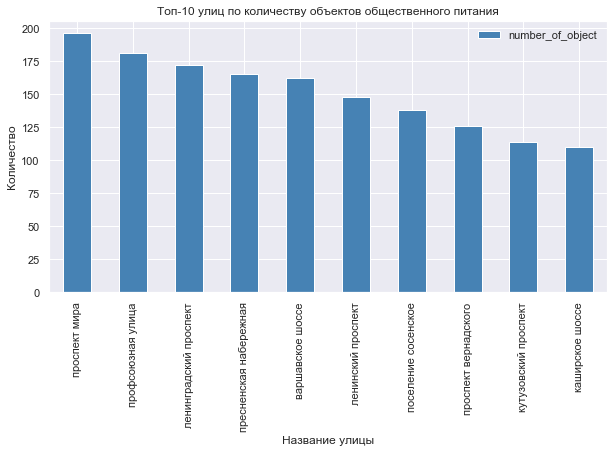

In [79]:
# строим график топ-10 улиц по количеству объектов общественного питания
top_streets.plot(x='street', kind='bar', grid=True, color="steelblue", figsize=(10, 5))
#plt.xticks(rotation=60)
plt.title('Топ-10 улиц по количеству объектов общественного питания')
plt.xlabel('Название улицы')
plt.ylabel('Количество')
plt.show()

In [80]:
# импортируем информацию с названиями округов из источника "МОСГАЗ"
from io import BytesIO
import requests
spreadsheet_id = '1K83j_yl9b52m4qg5VidHLxLUNTNUoEH39BqyGdMBSek '
file_name = 'https://questhint.ru/wp-content/uploads/2022/04/mosgaz-streets.csv'.format(spreadsheet_id)
r = requests.get(file_name)
mos_gaz = pd.read_csv(BytesIO(r.content))

# удаляем дубликаты
mos_gaz = mos_gaz.drop_duplicates().reset_index(drop=True)
mos_gaz.duplicated().sum()

# приведем все записи в стодбцах "streetname" и "area" к нижнему регистру
mos_gaz['streetname'] = mos_gaz['streetname'].str.lower()
mos_gaz['area'] = mos_gaz['area'].str.lower()
mos_gaz.head()

,streetname,areaid,okrug,area
0,выставочный переулок,17,ЦАО,пресненский район
1,улица гашека,17,ЦАО,пресненский район
2,большая никитская улица,17,ЦАО,пресненский район
3,глубокий переулок,17,ЦАО,пресненский район
4,большой гнездниковский переулок,17,ЦАО,пресненский район


In [81]:
# переименуем столбец
mos_gaz = mos_gaz.rename(columns = {'streetname' : 'street'}) 

# соединяем таблицы 
full_top_streets = top_streets.merge(mos_gaz, on='street' , how='left')
full_top_streets.head()


,street,number_of_object,areaid,okrug,area
0,проспект мира,196,70.0,СВАО,алексеевский район
1,проспект мира,196,86.0,СВАО,ярославский район
2,проспект мира,196,78.0,СВАО,район марьина роща
3,проспект мира,196,79.0,СВАО,останкинский район
4,проспект мира,196,81.0,СВАО,район ростокино


In [82]:
for i in top_streets['street']:
    print(i, 'районы:', full_top_streets.query(f'street == "{i}"')['area'].unique())


проспект мира районы: ['алексеевский район' 'ярославский район' 'район марьина роща'
 'останкинский район' 'район ростокино' 'район свиблово' 'мещанский район']
профсоюзная улица районы: ['академический район' 'район черемушки' 'район ясенево' 'район коньково'
 'обручевский район' 'район теплый стан']
ленинградский проспект районы: ['район аэропорт' 'район беговой' 'хорошевский район' 'район сокол']
пресненская набережная районы: ['пресненский район']
варшавское шоссе районы: ['район чертаново центральное' 'район чертаново северное'
 'район чертаново южное' 'донской район' 'район нагатино-садовники'
 'нагорный район' 'район северное бутово' 'район южное бутово']
ленинский проспект районы: ['район проспект вернадского' 'район тропарево-никулино' 'донской район'
 'район гагаринский' 'ломоносовский район' 'обручевский район'
 'район теплый стан' 'район якиманка']
поселение сосенское районы: [nan]
проспект вернадского районы: ['район проспект вернадского' 'район раменки' 'район тропарево-н

In [83]:
districts = full_top_streets['area'].unique()
display('Топ-10 улиц по количеству объектов общественного питания находятся в следующих районах:', districts)
count_districts = len(pd.unique(full_top_streets['area'])) 
print('Количество районов:', count_districts)

'Топ-10 улиц по количеству объектов общественного питания находятся в следующих районах:'

array(['алексеевский район', 'ярославский район', 'район марьина роща',
       'останкинский район', 'район ростокино', 'район свиблово',
       'мещанский район', 'академический район', 'район черемушки',
       'район ясенево', 'район коньково', 'обручевский район',
       'район теплый стан', 'район аэропорт', 'район беговой',
       'хорошевский район', 'район сокол', 'пресненский район',
       'район чертаново центральное', 'район чертаново северное',
       'район чертаново южное', 'донской район',
       'район нагатино-садовники', 'нагорный район',
       'район северное бутово', 'район южное бутово',
       'район проспект вернадского', 'район тропарево-никулино',
       'район гагаринский', 'ломоносовский район', 'район якиманка', nan,
       'район раменки', 'район дорогомилово', 'район фили-давыдково',
       'район москворечье-сабурово', 'район орехово-борисово южное',
       'район орехово-борисово северное'], dtype=object)

Количество районов: 38


Топ-10 улицы по количеству объектов общественного питания проходят через 38 районов, которые в основном являются центральными.

# Количество улиц с одним объектом общественного питания


In [84]:
# объединяем таблицы
top_streets_1 = rest_data_street.merge(mos_gaz, on='street', how='left')

In [85]:
top_streets_1 = top_streets_1.query('number_of_object == 1')
print('Количество улиц с одним объектом общественного питания:', top_streets_1['street'].count())

Количество улиц с одним объектом общественного питания: 570


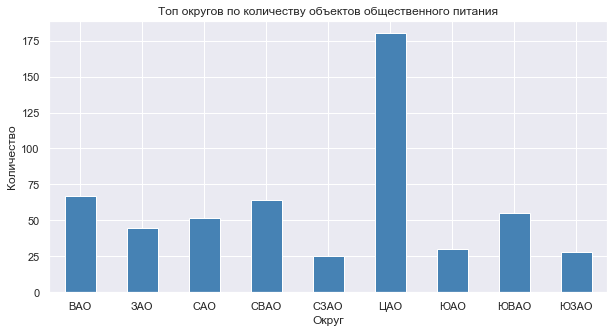

In [86]:
# смотрим округ
top_streets_1 = top_streets_1.query('okrug != "Зеленоград"')
top_streets_1.groupby('okrug')['okrug'].count().plot(x='okrug', kind='bar', grid=True, color="steelblue", figsize=(10, 5))
plt.xticks(rotation=0)
plt.title('Топ округов по количеству объектов общественного питания')
plt.xlabel('Округ')
plt.ylabel('Количество')
plt.show()

В основном улицы с одним объектом общественного питания находятся в центральном административном округе (ЦАО).

# Количество посадочных мест для улиц с большим количеством объектов общественного питания


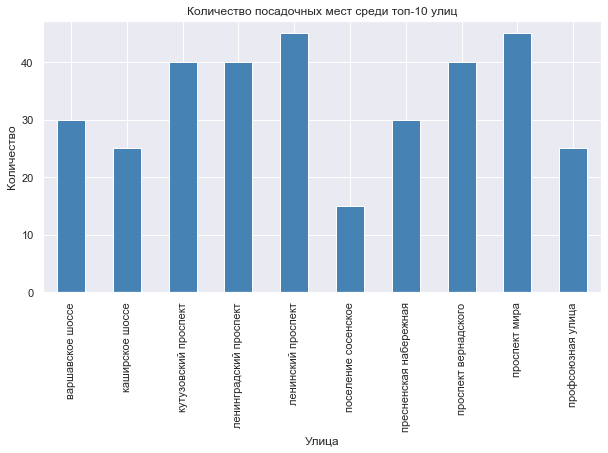

In [87]:
# количество посадочных мест
date_number = top_streets.merge(rest_data[['street', 'number']], on='street', how='left')
date_number.groupby('street')['number'].median().plot(x='street', kind='bar', grid=True, color="steelblue", figsize=(10, 5))
plt.title('Количество посадочных мест среди топ-10 улиц')
plt.xlabel('Улица')
plt.ylabel('Количество')
plt.show()

Для улиц с большим количеством объектов общественного питания характерно в среднем до 50 посадочных мест.

## Презентация

Презентация: https://disk.yandex.ru/d/XdLoQGUkHbVoMw

## Вывод

В данном анализе было выяснено, что наибольшую часть от видов общественного питания(ОП) составляет "кафе"(40%) далее идут "столовая", "ресторан", "предприятие быстрого обслуживания" (по 12-16%). Основную часть на рынке ОП составляют несетевые заведения (80%). Сетевое распространение в основном характерно для кафе, предприятий быстрого обслуживания и ресторанов. Для сетевых заведений характерно множеество объектов с небольшим числом посадочных мест. В столовых и ресторанах наибольшее среднее количество посадочных мест, далее идут кафе, буфеты и бары. Наименьшее количество посадочных мест в кафетериях и предприятиях быстрого обслуживания. В закусочных и магазинах их вовсе нет. На рынке общественного питания имеются 622 улицы с одним заведением, которые в основном находятся в центральном административном округе (ЦАО). На улицах с большим количеством объектов общественного питания характерно в среднем до 50 посадочных мест.


Топ-10 улиц по количеству объектов ОП в Москве:
1.	проспект мира (204)
2.	профсоюзная улица (182)
3.	ленинградский проспект	(171)
4.	пресненская набережная	(167)
5.	варшавское шоссе	(161)
6.	ленинский проспект	(147)
7.	проспект вернадского	(132)
8.	кутузовский проспект	(114)
9.	каширское шоссе	(112)
10.	кировоградская улица	(110)

Рекомендации о виде заведения:  
Для начала можно открыть несетевое кафе с небольшим количеством посадочных мест и подробно рассмотреть локацию в центральном административном округе (рассчитать проходимость клиентов, конкуренцию, среднюю окупаемость заведений и т.д.). Далее можно попробовать развить сеть, т.к. для сетевых заведений в основном характерны кафе с небольшим количестом посадочных мест. Для сетевизации заведения в Москве подойдут локации из списка топ-10 улиц по количеству объектов общественного питания.    
Роботы-официанты не дешевое оборудование, которое порой нужно ремонтировать, проводить диагностику и т.д., но это хорошее внедрение с точки зрения маркетинга т.к. это новый и уникальный продукт на рынке. Внедрение роботов-официантов поспособствует развитию PR-менеджмента заведения, приобретению постоянных клиентов, а также экономии на сотрудниках.